# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета. 

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [1]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.applications.densenet import DenseNet169
dnmodel = DenseNet169(include_top = False, input_shape = (32, 32, 3)) 

dnmodel.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']             
                       

In [ ]:
for layer in dnmodel.layers:
    layer.trainable = False

In [ ]:
tf.keras.datasets.cifar100.load_data(label_mode="fine")

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

169001437/169001437 [==============================] - 2s 0us/step


In [ ]:
print(x_train.shape,
y_train.shape,
x_test.shape,
y_test.shape,
sep = '\n')

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
X =[]
Y =[]

for img in x_train:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) # Значения A и B находятся в диапазоне от -127 до 128, 
      # поэтому мы делим значения на 128, чтобы ограничить значения от -1 до 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #размерности должны быть одинаковыми для X и Y
print(X.shape)
print(Y.shape)
print(x_train[0].shape)

(50000, 32, 32, 1)
(50000, 32, 32, 2)
(32, 32, 3)


In [ ]:
dense169features = []

for i, sample in enumerate(X[:20000]):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,32,32,3))
  sample = keras.applications.densenet.preprocess_input(sample)
  prediction = dnmodel.predict(sample)
  prediction = prediction.reshape((1,1,1664))
  dense169features.append(prediction)
  print(i)
dense169features = np.array(dense169features)
print(dense169features.shape)

Выходные данные были обрезаны до нескольких последних строк (5000).
17500
1/1 [==============================] - 0s 37ms/step
17501
1/1 [==============================] - 0s 38ms/step
17502
1/1 [==============================] - 0s 36ms/step
17503
1/1 [==============================] - 0s 34ms/step
17504
1/1 [==============================] - 0s 42ms/step
17505
1/1 [==============================] - 0s 32ms/step
17506
1/1 [==============================] - 0s 40ms/step
17507
1/1 [==============================] - 0s 36ms/step
17508
1/1 [==============================] - 0s 31ms/step
17509
1/1 [==============================] - 0s 33ms/step
17510
1/1 [==============================] - 0s 41ms/step
17511
1/1 [==============================] - 0s 34ms/step
17512
1/1 [==============================] - 0s 36ms/step
17513
1/1 [==============================] - 0s 31ms/step
17514
1/1 [==============================] - 0s 34ms/step
17515
1/1 [==============================] - 0s 46ms/step
1751

In [ ]:
with open('/content/drive/MyDrive/trin.npy', 'wb') as f:
    np.save(f, dense169features)

In [ ]:
with open('/content/drive/MyDrive/trin.npy', 'rb') as f:
    dense169features = np.load(f)

In [ ]:
dense169features_val = []

for i, sample_val in enumerate(X[25000:30000]):
  sample_val = gray2rgb(sample_val)
  sample_val = sample_val.reshape((1,32,32,3))
  sample_val = keras.applications.densenet.preprocess_input(sample_val)
  prediction_val = dnmodel.predict(sample_val)
  prediction_val = prediction_val.reshape((1,1,1664))
  dense169features_val.append(prediction_val)
  print(i)
dense169features_val = np.array(dense169features_val)
print(dense169features_val.shape)

Выходные данные были обрезаны до нескольких последних строк (5000).
2500
1/1 [==============================] - 0s 43ms/step
2501
1/1 [==============================] - 0s 45ms/step
2502
1/1 [==============================] - 0s 68ms/step
2503
1/1 [==============================] - 0s 48ms/step
2504
1/1 [==============================] - 0s 44ms/step
2505
1/1 [==============================] - 0s 45ms/step
2506
1/1 [==============================] - 0s 42ms/step
2507
1/1 [==============================] - 0s 43ms/step
2508
1/1 [==============================] - 0s 46ms/step
2509
1/1 [==============================] - 0s 48ms/step
2510
1/1 [==============================] - 0s 43ms/step
2511
1/1 [==============================] - 0s 45ms/step
2512
1/1 [==============================] - 0s 43ms/step
2513
1/1 [==============================] - 0s 47ms/step
2514
1/1 [==============================] - 0s 46ms/step
2515
1/1 [==============================] - 0s 55ms/step
2516
1/1 [==========

In [ ]:
with open('/content/drive/MyDrive/val.npy', 'wb') as m:
    np.save(m, dense169features_val)

In [ ]:
with open('/content/drive/MyDrive/val.npy', 'rb') as m:
    dense169features_val = np.load(m)

In [ ]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(1,1,1664)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()


model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1, 256)         3834112   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 2, 2, 128)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 32)          1

In [ ]:
model.fit(dense169features, Y[:20000], verbose=1, epochs=50, batch_size = 500, validation_data=(dense169features_val, Y[25000:30000]), validation_batch_size = 125)

model.save('/content/drive/MyDrive/colorize_autoencoder_densenet196.h5')

Epoch 1/50
 4/40 [==>...........................] - ETA: 47s - loss: 0.0165 - accuracy: 0.5676

KeyboardInterrupt: ignored

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/colorize_autoencoder_densenet196.h5',
                                   custom_objects=None,
                                   compile=True)

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np

def show(path):

  test = img_to_array(load_img(path))
  orig = test.copy()
  test = cv2.resize(test, (32,32))
  test*= 1.0/255
  lab = rgb2lab(test)
  l = lab[:,:,0]
  L = gray2rgb(l)
  L = L.reshape((1,32,32,3))
  L = keras.applications.densenet.preprocess_input(L)

  densepred = dnmodel.predict(L)
  ab = model.predict(densepred)


  ab = ab*128
  cur = np.zeros((32, 32, 3))
  cur[:,:,0] = l
  cur[:,:,1:] = ab

  imsave('/content/drive/MyDrive/new.jpg', lab2rgb(cur))
  
  # imo = cv2.imread(path)
  # imo = imo[:,:,0]
  # imo = gray2rgb(imo)

  imo = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
  imo = cv2.resize(imo, (256, 256))

  im = cv2.imread("/content/drive/MyDrive/new.jpg")
  im = cv2.resize(im, (256, 256))
  pred = np.concatenate((imo, im), axis=1)
  cv2_imshow(pred)

1/1 [==============================] - 0s 207ms/step


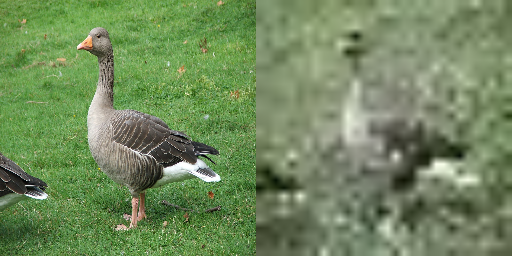

1/1 [==============================] - 0s 20ms/step


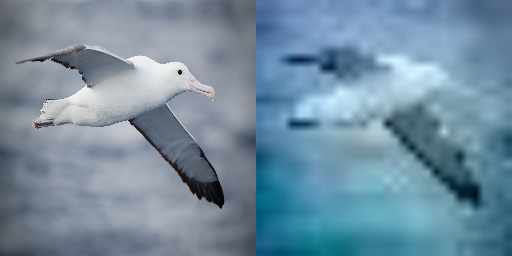

1/1 [==============================] - 0s 22ms/step


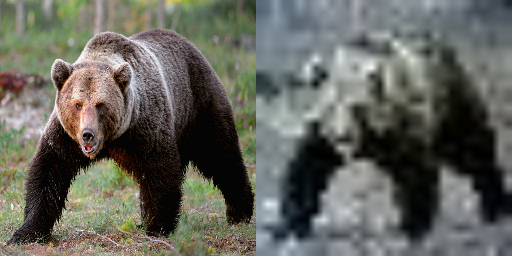

1/1 [==============================] - 0s 19ms/step


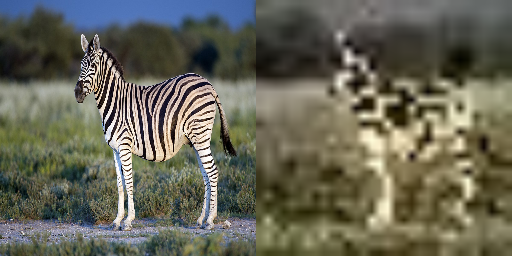

1/1 [==============================] - 0s 21ms/step


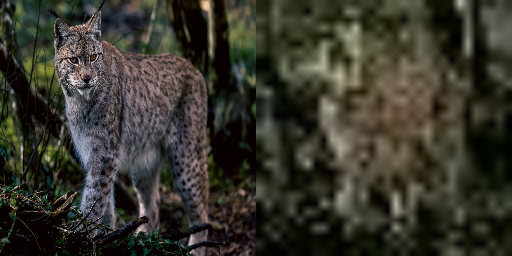

In [ ]:
img = ['/content/drive/MyDrive/img1.jpg', 
       '/content/drive/MyDrive/img2.jpg', 
       '/content/drive/MyDrive/img3.jpg', 
       '/content/drive/MyDrive/img4.jpg', 
       '/content/drive/MyDrive/img5.jpg']

for i in range(len(img)):
  show(img[i])

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.

    """
    array = np.array(array, dtype=np.float32)
    array = array / 255.0
    array = np.reshape(array, (len(array), 32, 32, 3))
    return array


def noise(array):
    """
    Добавляет случайный шум к каждому изображению в предоставленном массиве.

    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    n = 8

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(32, 32, 3))
        # plt.show()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(32, 32, 3))
        # plt.show()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
from imutils import paths
from sklearn.model_selection import train_test_split
import cv2

imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/night_img/")))
data = []

for imagePath in imagePaths:
  image = cv2.imread(imagePath) # загружаем изображение
  image = cv2.resize(image, (32, 32))
  data.append(image) # добавляем в список

In [ ]:
(trainX, testX) = train_test_split(data, test_size=0.2, random_state=42)

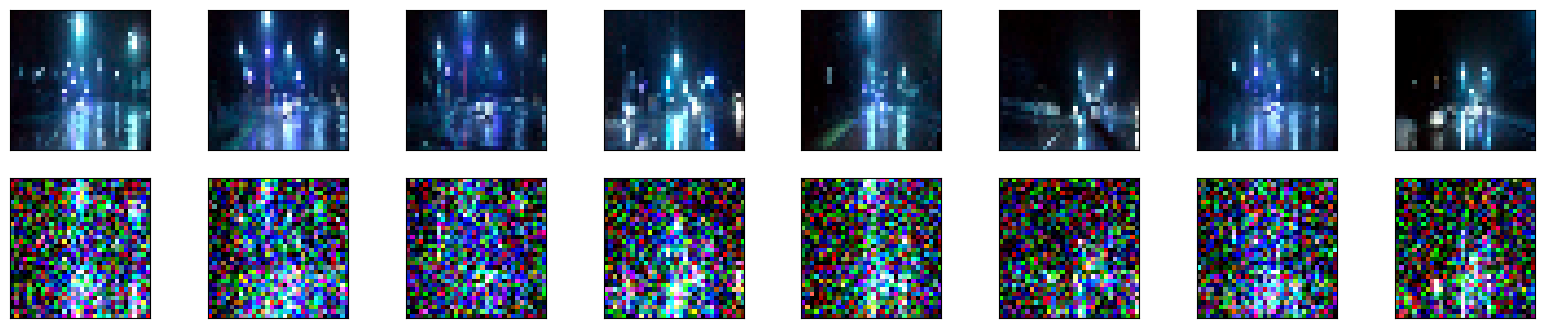

In [ ]:
# Нормализация и изменение формы данных
trainX = preprocess(trainX)
testX = preprocess(testX)

# Создание копии данных с добавленным шумом
noisy_trainX_data = noise(trainX)
noisy_testX_data = noise(testX)

# Отображение данных выборки и его версии с добавленным шумом
display(trainX, noisy_trainX_data)


In [ ]:
input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 16)          4624

In [ ]:
autoencoder.fit(
    x=trainX,
    y=trainX,
    epochs=150,
    batch_size=100,
    shuffle=True,
    validation_data=(testX, testX),
)

Epoch 1/150
9/9 [==============================] - 3s 61ms/step - loss: 0.6856 - val_loss: 0.6561
Epoch 2/150
9/9 [==============================] - 0s 22ms/step - loss: 0.6194 - val_loss: 0.5778
Epoch 3/150
9/9 [==============================] - 0s 22ms/step - loss: 0.5613 - val_loss: 0.5347
Epoch 4/150
9/9 [==============================] - 0s 18ms/step - loss: 0.5167 - val_loss: 0.4858
Epoch 5/150
9/9 [==============================] - 0s 19ms/step - loss: 0.4683 - val_loss: 0.4427
Epoch 6/150
9/9 [==============================] - 0s 19ms/step - loss: 0.4331 - val_loss: 0.4230
Epoch 7/150
9/9 [==============================] - 0s 18ms/step - loss: 0.4201 - val_loss: 0.4157
Epoch 8/150
9/9 [==============================] - 0s 18ms/step - loss: 0.4145 - val_loss: 0.4121
Epoch 9/150
9/9 [==============================] - 0s 20ms/step - loss: 0.4100 - val_loss: 0.4071
Epoch 10/150
9/9 [==============================] - 0s 17ms/step - loss: 0.4060 - val_loss: 0.4033
Epoch 11/150
9/9 [=

7/7 [==============================] - 0s 13ms/step


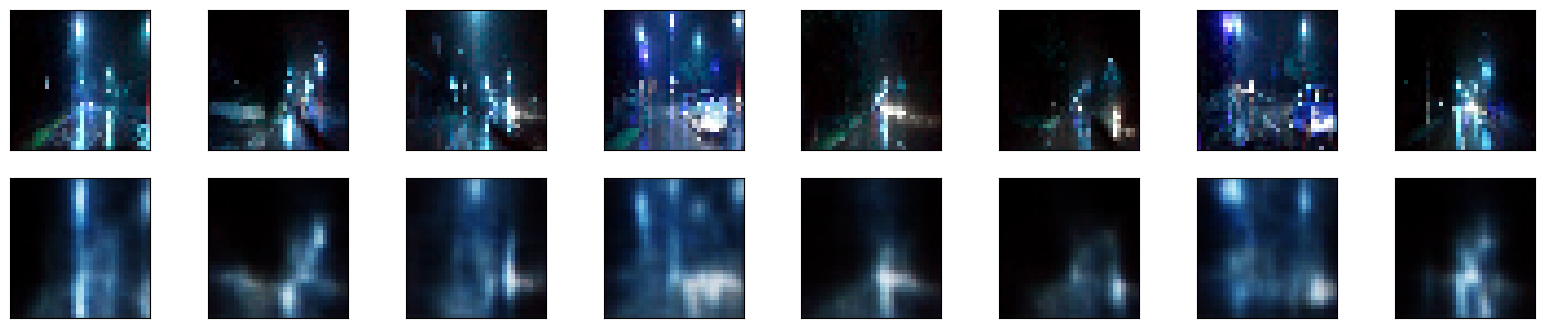

In [ ]:
predictions = autoencoder.predict(testX)
display(testX, predictions)

In [ ]:
autoencoder.fit(
    x=noisy_trainX_data,
    y=trainX,
    epochs=100,
    batch_size=100,
    shuffle=True,
    validation_data=(noisy_testX_data, testX),
)

Epoch 1/100
9/9 [==============================] - 0s 38ms/step - loss: 0.3627 - val_loss: 0.3621
Epoch 2/100
9/9 [==============================] - 0s 31ms/step - loss: 0.3627 - val_loss: 0.3626
Epoch 3/100
9/9 [==============================] - 0s 23ms/step - loss: 0.3627 - val_loss: 0.3626
Epoch 4/100
9/9 [==============================] - 0s 22ms/step - loss: 0.3627 - val_loss: 0.3630
Epoch 5/100
9/9 [==============================] - 0s 27ms/step - loss: 0.3624 - val_loss: 0.3685
Epoch 6/100
9/9 [==============================] - 0s 27ms/step - loss: 0.3650 - val_loss: 0.3676
Epoch 7/100
9/9 [==============================] - 0s 27ms/step - loss: 0.3643 - val_loss: 0.3641
Epoch 8/100
9/9 [==============================] - 0s 39ms/step - loss: 0.3635 - val_loss: 0.3623
Epoch 9/100
9/9 [==============================] - 0s 46ms/step - loss: 0.3625 - val_loss: 0.3622
Epoch 10/100
9/9 [==============================] - 0s 19ms/step - loss: 0.3622 - val_loss: 0.3621
Epoch 11/100
9/9 [=

7/7 [==============================] - 0s 4ms/step


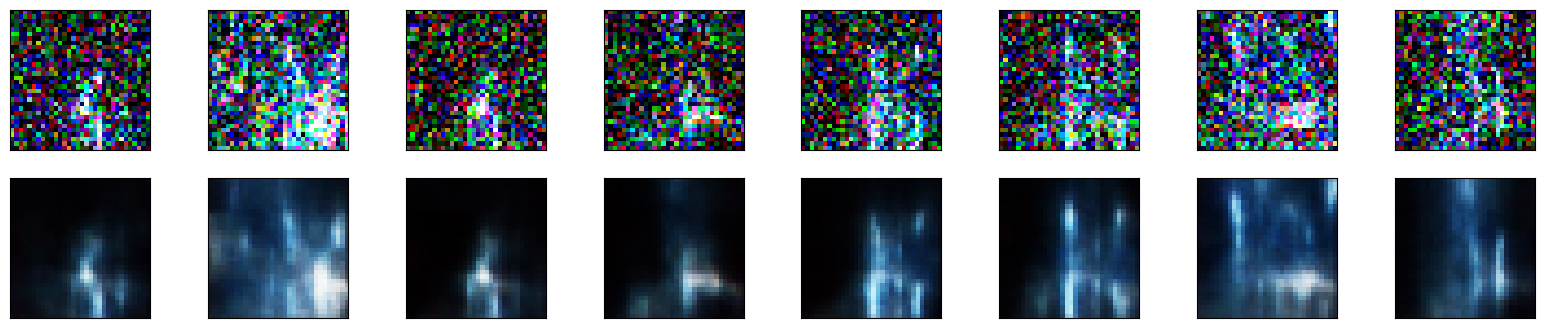

In [ ]:
predictions = autoencoder.predict(noisy_testX_data)
display(noisy_testX_data, predictions)

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку. 

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [3]:
from imutils import paths
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/night_image/")))


In [4]:
data128 = []
data256 = []

for imagePath128 in imagePaths:
  image128 = cv2.imread(imagePath128) # загружаем изображение
  image128 = cv2.resize(image128, (128, 128))
  data128.append(image128) # добавляем в список

for imagePath256 in imagePaths:
  image256 = cv2.imread(imagePath256) # загружаем изображение
  image256 = cv2.resize(image256, (256, 256))
  data256.append(image256) # добавляем в список

In [5]:
 x_train, x_test, y_train, y_test = train_test_split(data128, data256, test_size=0.2, random_state=42)

In [6]:
def preprocess128(array128):

    array128 = np.array(array128, dtype=np.float32)
    array128 = array128 / 255.0
    array128 = np.reshape(array128, (len(array128), 128, 128, 3))
    return array128

def preprocess256(array256):

    array256 = np.array(array256, dtype=np.float32)
    array256 = array256 / 255.0
    array256 = np.reshape(array256, (len(array256), 256, 256, 3))
    return array256

In [7]:
x_train = preprocess128(x_train)
x_test = preprocess128(x_test)
y_train = preprocess256(y_train)
y_test = preprocess256(y_test)


print(len(x_train), len(y_train), len(x_test), len(y_test))

800 800 201 201


In [8]:
x_train = x_train[:400]
x_test = x_test[:100]
y_train = y_train[:400]
y_test = y_test[:100]

In [9]:
print(len(x_train))
print(x_train.shape)
print(len(y_train))
print(y_train.shape)
print(len(x_test))
print(x_test.shape)
print(len(y_test))
print(y_test.shape)

400
(400, 128, 128, 3)
400
(400, 256, 256, 3)
100
(100, 128, 128, 3)
100
(100, 256, 256, 3)


In [37]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.optimizers import Adam

opt = Adam(learning_rate = 0.0001)

input128 = layers.Input(shape=(128, 128, 3))

# Encoder
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(input128)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
# x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)


bigsize = Model(input128, x)
bigsize.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
bigsize.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 64, 64, 64)       3692

In [ ]:
import tensorflow as tf

In [ ]:
bigsize = tf.keras.models.load_model('/content/drive/MyDrive/bigsize.h5',
                                   custom_objects=None,
                                   compile=True)

In [38]:
history2 = bigsize.fit(
    x_train,
    y_train,
    epochs=2,
    batch_size=20,
    shuffle=True,
    validation_data=(x_test, y_test),
)

Epoch 1/2
20/20 [==============================] - 12s 544ms/step - loss: 0.6383 - accuracy: 0.7130 - val_loss: 0.6213 - val_accuracy: 0.7733
Epoch 2/2
20/20 [==============================] - 10s 523ms/step - loss: 0.6316 - accuracy: 0.7872 - val_loss: 0.6313 - val_accuracy: 0.7733


In [ ]:
bigsize.save('/content/drive/MyDrive/bigsize.h5')

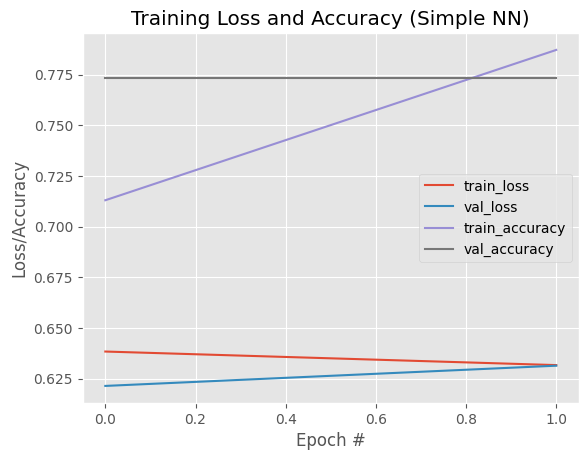

In [40]:
his = history2

N = np.arange(0, 2)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, his.history["loss"], label="train_loss")
plt.plot(N, his.history["val_loss"], label="val_loss")
plt.plot(N, his.history["accuracy"], label="train_accuracy")
plt.plot(N, his.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [41]:
test_img = x_test[0]

# test_img = cv2.imread(test_img) # загружаем изображение
# test_img = cv2.resize(test_img, (128, 128))
# test_img = np.array(test_img, dtype=np.float32)
# test_img = test_img / 255.0
test_img = np.reshape(test_img, (1, 128, 128, 3))

In [42]:
test_pred = bigsize.predict(test_img)

1/1 [==============================] - 0s 115ms/step


In [43]:
test_img = test_img[0,]
test_pred = test_pred[0,]

In [ ]:
np.unique(test_pred)

array([0.4380929 , 0.43820357, 0.43964088, ..., 0.51019955, 0.5125938 ,
       0.51298547], dtype=float32)

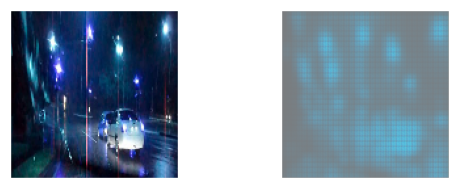

In [44]:
ax = plt.subplot(2, 2, 1)
plt.imshow(test_img)
        # plt.show()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 2, 2)
plt.imshow(test_pred)
        # plt.show()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()